# When BR Can Go Negative: Positivity Violations in Bloch-Redfield Dynamics

This notebook demonstrates conditions under which the Bloch-Redfield (BR) master equation can produce density matrices with negative eigenvalues, violating complete positivity (CP). We explore two minimal examples where non-secular effects lead to transient negativity.

## Conditions for Positivity Failure in Bloch-Redfield Equation

Positivity can fail if one (or more) of these hold:

1. **Non-secular couplings are relevant**: There exist $\omega \neq \omega'$ with $|\omega - \omega'| \lesssim \gamma$ (rates). Then the $e^{-i(\omega - \omega')t}$ terms don't average out and the generator is not GKSL.

2. **Bath not "short-memory" enough / strong coupling**: $\tau_E \not\ll \tau_S$, or coupling not weak ⇒ Markov/Born steps are marginal.

## Example A: One Qubit with Transverse Coupling

Let $H_S = \frac{\omega_0}{2} \sigma_z$, and couple via $S = \sigma_x = \sigma^+ + \sigma^-$.

The non-secular Redfield dissipator contains oscillating terms $e^{\pm i 2\omega_0 t} \Gamma(\pm \omega_0) (\sigma^\pm \rho \sigma^\pm)$ that are not Lindblad form.

If $\omega_0 \sim \gamma$, there exist initial states (e.g. $|+x\rangle$) for which the Bloch-vector norm temporarily grows above 1, hence $\rho$ has negative eigenvalues at short times $O(\gamma / \omega_0)$.

Takeaway: if $\gamma / \omega_0 \gtrsim 0.1$, secularize or coarse-grain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, sigmaz, sigmax, sigmay, sigmap, sigmam, Qobj, brmesolve, tensor
from qutip import BosonicEnvironment, OhmicEnvironment
from diagnostics import trajectory_min_eigs
from plotting import style
style()

In [2]:
# Example A: Qubit with transverse coupling
w0 = 1.0  # qubit frequency
gamma_ratio = 0.9  # gamma / w0 ≈ 0.9 to trigger stronger non-secular effects
gamma = gamma_ratio * w0

H = 0.5 * w0 * sigmaz()
S = sigmax()  # transverse coupling

# Bath: Ohmic bath for demonstration
bath = OhmicEnvironment(T=0, wc=10*w0, alpha=gamma / (np.pi * w0), s=1.0)

# Initial state: |+x> = (|0> + |1>)/sqrt(2)
psi0 = (basis(2,0) + basis(2,1)).unit()

tlist = np.linspace(0, 10 / gamma, 200)  # short times

/home/leopold/miniconda3/envs/redfield/lib/python3.13/site-packages/qutip/core/environment.py:1647: UserWarning: The mpmath module is required for some operations on Ohmic environments, but it is not installed.
  warnings.warn(


In [3]:
# Non-secular BR: sec_cutoff = -1 (keep all terms)
res_br_ns = brmesolve(H=H, psi0=psi0, tlist=tlist, a_ops=[[S, bath]], e_ops=[], sec_cutoff=-1)

# Secular BR: sec_cutoff = w0/2 or something small
res_br_sec = brmesolve(H=H, psi0=psi0, tlist=tlist, a_ops=[[S, bath]], e_ops=[], sec_cutoff=0.1*w0)

min_eigs_ns = trajectory_min_eigs(res_br_ns.states)
min_eigs_sec = trajectory_min_eigs(res_br_sec.states)

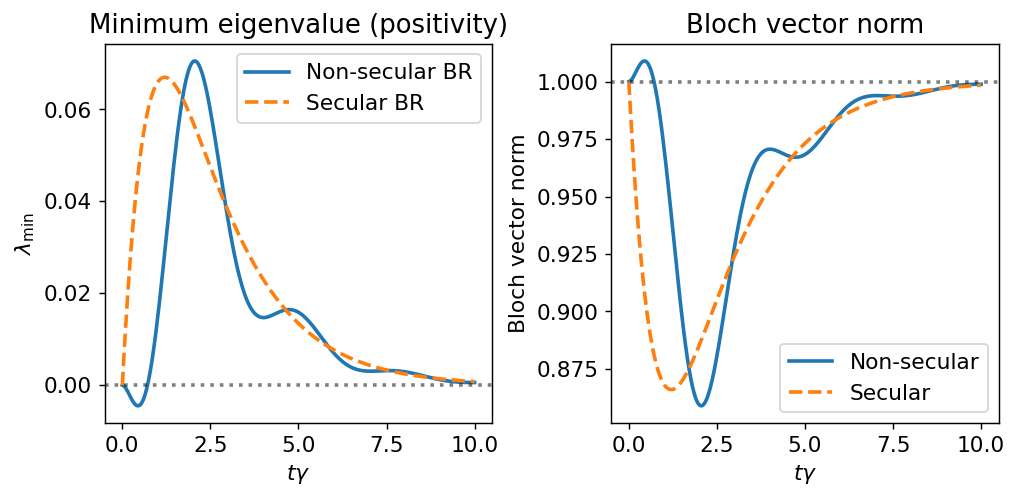

In [4]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(tlist * gamma, min_eigs_ns, label='Non-secular BR')
plt.plot(tlist * gamma, min_eigs_sec, label='Secular BR', ls='--')
plt.axhline(0, color='k', ls=':', alpha=0.5)
plt.xlabel(r'$t \gamma$')
plt.ylabel(r'$\lambda_{\min}$')
plt.title('Minimum eigenvalue (positivity)')
plt.legend()

plt.subplot(1,2,2)
# Plot Bloch vector norm or something
from qutip import expect
bloch_x = expect(sigmax(), res_br_ns.states)
bloch_y = expect(sigmay(), res_br_ns.states)  # need sigmay
from qutip import sigmay
bloch_y = expect(sigmay(), res_br_ns.states)
bloch_z = expect(sigmaz(), res_br_ns.states)
bloch_norm = np.sqrt(bloch_x**2 + bloch_y**2 + bloch_z**2)
plt.plot(tlist * gamma, bloch_norm, label='Non-secular')
bloch_x_sec = expect(sigmax(), res_br_sec.states)
bloch_y_sec = expect(sigmay(), res_br_sec.states)
bloch_z_sec = expect(sigmaz(), res_br_sec.states)
bloch_norm_sec = np.sqrt(bloch_x_sec**2 + bloch_y_sec**2 + bloch_z_sec**2)
plt.plot(tlist * gamma, bloch_norm_sec, label='Secular', ls='--')
plt.axhline(1, color='k', ls=':', alpha=0.5)
plt.xlabel(r'$t \gamma$')
plt.ylabel('Bloch vector norm')
plt.title('Bloch vector norm')
plt.legend()
plt.tight_layout()
plt.show()

## Example B: Three-Level V-System with Near-Degenerate Transitions

Let $|g\rangle$ ground, $|e_1\rangle, |e_2\rangle$ excited with $H_S = \omega_1 |e_1\rangle\langle e_1| + \omega_2 |e_2\rangle\langle e_2|$, $\delta \equiv \omega_2 - \omega_1 \ll \gamma$.

Couple both transitions to the same bath: $S_1 = |g\rangle\langle e_1| + |e_1\rangle\langle g|$, $S_2 = |g\rangle\langle e_2| + |e_2\rangle\langle g|$.

The Redfield equation has cross-frequency terms $e^{-i(\omega_2 - \omega_1)t} \Gamma_{12}(\omega_1) [S_1(\omega_1), S_2(\omega_2) \rho]$ that don't average out since $\delta$ is small.

Starting from $|\psi\rangle = (|e_1\rangle - |e_2\rangle)/\sqrt{2}$, non-secular BR can yield negative eigenvalues.

In [6]:
# Example B: Three-level V-system
w1 = 1.0
delta = 0.1  # small splitting
w2 = w1 + delta
gamma = 0.5  # rate

# Basis: |g>, |e1>, |e2>
g = basis(3, 0)
e1 = basis(3, 1)
e2 = basis(3, 2)

H = w1 * e1 * e1.dag() + w2 * e2 * e2.dag()

# Coupling operators
S1 = g * e1.dag() + e1 * g.dag()
S2 = g * e2.dag() + e2 * g.dag()

# Bath: same for both, assume identical
bath = OhmicEnvironment(T=0, wc=10*w1, alpha=gamma / (np.pi * w1), s=1.0)

# Initial state: coherent superposition (|e1> - |e2>)/sqrt(2)
psi0 = (e1 - e2).unit()

tlist = np.linspace(0, 20 / gamma, 300)

In [ ]:
# Non-secular BR
res_br_ns_b = brmesolve(H=H, psi0=psi0, tlist=tlist, a_ops=[[S1, bath], [S2, bath]], e_ops=[], sec_cutoff=-1)

# secular: keep terms within delta
res_br = brmesolve(H=H, psi0=psi0, tlist=tlist, a_ops=[[S1, bath], [S2, bath]], e_ops=[], sec_cutoff=delta/2)

min_eigs_ns_b = trajectory_min_eigs(res_br_ns_b.states)
min_eigs = trajectory_min_eigs(res_br.states)

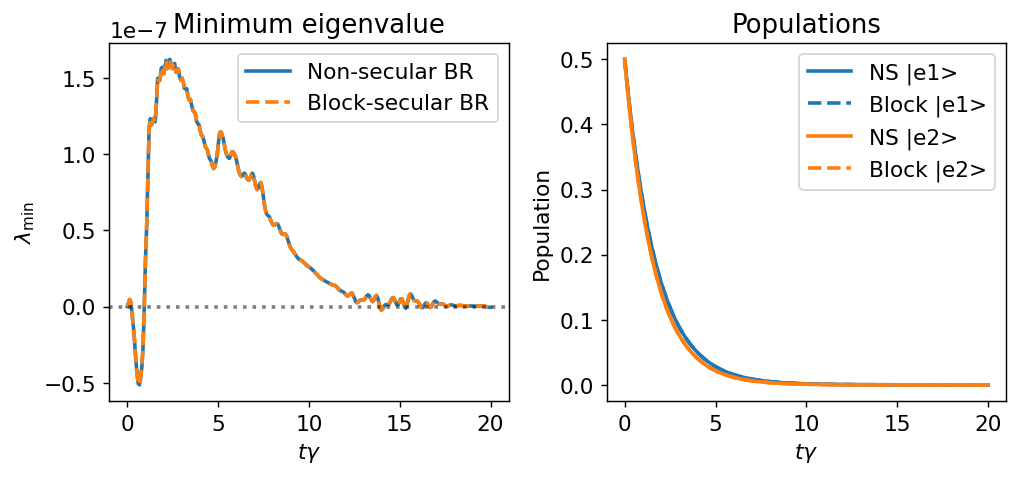

In [8]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(tlist * gamma, min_eigs_ns_b, label='Non-secular BR')
plt.plot(tlist * gamma, min_eigs, label='Secular BR', ls='--')
plt.axhline(0, color='k', ls=':', alpha=0.5)
plt.xlabel(r'$t \gamma$')
plt.ylabel(r'$\lambda_{\min}$')
plt.title('Minimum eigenvalue')
plt.legend()

plt.subplot(1,2,2)
# Populations
pops_ns = [expect(e1 * e1.dag(), res_br_ns_b.states), expect(e2 * e2.dag(), res_br_ns_b.states)] # expect(g * g.dag(), res_br_ns_b.states), 
pops = [expect(e1 * e1.dag(), res_br.states), expect(e2 * e2.dag(), res_br.states)]#  expect(g * g.dag(), res_br.states), 
labels = ['|e1>', '|e2>'] # '|g>', 
for i in range(len(labels)):
    plt.plot(tlist * gamma, pops_ns[i], label=f'NS {labels[i]}', color=f'C{i}')
    plt.plot(tlist * gamma, pops[i], label=f'Sec {labels[i]}', color=f'C{i}', ls='--')
plt.xlabel(r'$t \gamma$')
plt.ylabel('Population')
plt.title('Populations')
plt.legend()
plt.tight_layout()
plt.show()

## Summary
print("Min eigenvalue for Example A (secular):", min(min_eigs_sec))
These examples illustrate how non-secular terms in the Bloch-Redfield equation can lead to violations of complete positivity. In practice, secular approximations or coarse-graining should be applied when $\gamma / \omega \gtrsim 0.1$ or when there are near-degenerate transitions.

In [9]:
## Summary
print("Min eigenvalue for Example A (secular):", min(min_eigs_sec))
# These examples illustrate how non-secular terms in the Bloch-Redfield equation can lead to violations of complete positivity. In practice, secular approximations or coarse-graining should be applied when $\gamma / \omega \gtrsim 0.1$ or when there are near-degenerate transitions.

Min eigenvalue for Example A (secular): 0.0
